### Library 

In [475]:
import sys
import os
import datetime
import pandas as pd
import numpy as np
import pickle
from matplotlib import pyplot as plt
import seaborn as sn
from scipy import stats

path_main_folder = '/home/antorosi/Documents/AutoEncoder'

sys.path.append(path_main_folder)

from CVAE.cvae import compile_cvae, run_cvae
from CVAE.cvae_model import CVAE
from conso.load_shape_data import *  
from conso.conso_helpers import plot_latent_space_projection, pyplot_latent_space_projection_temp, pyplot_latent_space_projection_error
from sklearn.manifold import TSNE

### Load and shape data 

In [3]:
# Load raw data
path_data = os.path.join(path_main_folder, 'data')
dict_data_conso = load_data_conso(path_data)

In [4]:
# Load Holiday day information
holiday_days_csv = os.path.join(path_data, "joursFeries.csv")
holiday_days_df = pd.read_csv(holiday_days_csv, sep=";")
holiday_days_df.ds = pd.to_datetime(holiday_days_df.ds)
holiday_days_df['is_hd'] = 1

In [5]:
# Unifomization
data_conso_df, dict_colnames_conso = get_uniformed_data_conso(dict_data_conso)

In [333]:
# Change ganularity ?
name_granu = '30m'
data_conso_df = change_granularity(data_conso_df, granularity="30min")

In [334]:
# Get x_conso dataframe for autoencoder purpose
x_conso = get_x_conso_autoencoder(data_conso_df, dict_colnames_conso)

### Build dataset 

In [335]:
# Split train and test
#date_test_start = datetime.date(2014,1,1)
#date_test_end = datetime.date(2015,1,1)
#dict_xconso = get_train_test_x_conso(x_conso, date_test_start, date_test_end)

dict_xconso = {'train': x_conso}

In [336]:
# Normalize x_conso
type_scaler = 's'
dict_xconso, _ = normalize_xconso(dict_xconso, dict_colnames_conso, type_scaler = 'standard')

In [357]:
name_type_cond = 'm-wd'
name_train = '0' # 1: first period ; 0 all periods
name_type_x = 'c-temp'
type_x = ['conso', 'temperature']
type_cond = ['month', 'weekday']

In [358]:
dataset = get_dataset_autoencoder(dict_xconso=dict_xconso, type_x=type_x, type_cond=type_cond)

In [359]:
dataset['train']['x'][1].shape

(1830, 14)

### Build model

In [360]:
path_out = os.path.join(path_main_folder, 'out')

In [617]:
# Parameters
cond_dim = dataset['train']['x'][1].shape[1]
e_dims=[48,24,12]
d_dims=[12,24,48]
input_dim = 96
z_dim= 10
beta = 0.5

In [612]:
name_model = 'cvae_conso_e48-24-12_d12-24-48_gran-{}_x-{}_cond-{}'.format(name_granu,name_type_x, name_type_cond)
#name_model = 'cvae_classification'

In [613]:
name_model

'cvae_conso_e48-24-12_d12-24-48_gran-30m_x-c-temp_cond-m-wd'

In [614]:
model = CVAE(input_dim=imput_dim
             cond_dim=cond_dim, 
             e_dims=e_dims, 
             d_dims=d_dims, 
             z_dim=z_dim, 
             beta=beta,
             name=name_model, 
             output=path_out)

SyntaxError: invalid syntax (<ipython-input-614-52935347fdee>, line 2)

### Trainning model 

In [615]:
model.main_train(dataset, training_epochs=200, batch_size=20, verbose=False)



--- START TRAINING ---



AttributeError: 'int' object has no attribute 'ndim'

In [616]:
with open(os.path.join(path_out,name_model,"config.txt"),'w') as file: 
    file.write(str(cond_dim) + '\n') 
    file.write(str(e_dims) + '\n') 
    file.write(str(d_dims) + '\n') 
    file.write(str(z_dim) + '\n')
    file.write(str(beta) + '\n')

## Loading model 

In [596]:
dataset['train']['x'] 

[array([[ 0.43533942,  0.30373645,  0.07418278, ..., -0.60496003,
         -0.63055737, -0.65150065],
        [ 0.39383772,  0.25062763,  0.00988437, ..., -0.68788694,
         -0.71433048, -0.73231208],
        [ 0.38005949,  0.24044009,  0.01739977, ..., -0.82073924,
         -0.82898962, -0.85416386],
        ...,
        [ 1.33167593,  1.19397713,  0.96742963, ..., -0.80529622,
         -0.79937287, -0.80000751],
        [ 1.0443372 ,  0.88233861,  0.65328597, ..., -0.18820999,
         -0.20069134, -0.21824984],
        [ 0.45337638,  0.30014576,  0.07885903, ..., -0.55016904,
         -0.54466878, -0.54466878]]), array([[0, 0, 0, ..., 1, 0, 1],
        [0, 0, 0, ..., 1, 1, 0],
        [0, 0, 0, ..., 1, 1, 0],
        ...,
        [0, 0, 0, ..., 1, 0, 1],
        [0, 0, 0, ..., 1, 1, 0],
        [0, 0, 0, ..., 1, 1, 0]], dtype=uint8), 2]

In [581]:
#model.load_model(os.path.join(path_out, name_model, 'models'))

### Analysis of the latent space

In [582]:
name_set_plot = 'train'
version = '-v2'

In [583]:
x_encoded = model.encoder.predict(dataset[name_set_plot]['x'])[0]

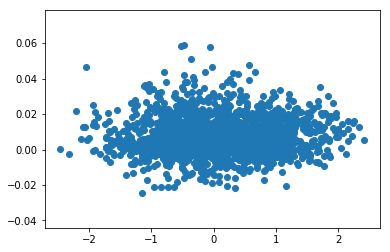

In [555]:
plt.scatter(x_encoded[:,0], x_encoded[:,9])

In [584]:
# t-sne if latent space more than 2 dimension
x_encoded = TSNE(n_components=2).fit_transform(x_encoded)

In [585]:
calendar_info = pd.DataFrame(dataset[name_set_plot]['ds'])
calendar_info['month'] = calendar_info.ds.dt.month
calendar_info['weekday'] = calendar_info.ds.dt.weekday
calendar_info['is_weekday'] = (calendar_info.weekday < 5).apply(lambda x:int(x))
calendar_info = pd.merge(calendar_info, holiday_days_df[['ds', 'is_hd']], on='ds', how ='left')
calendar_info.loc[calendar_info['is_hd'].isna(),'is_hd'] = 0

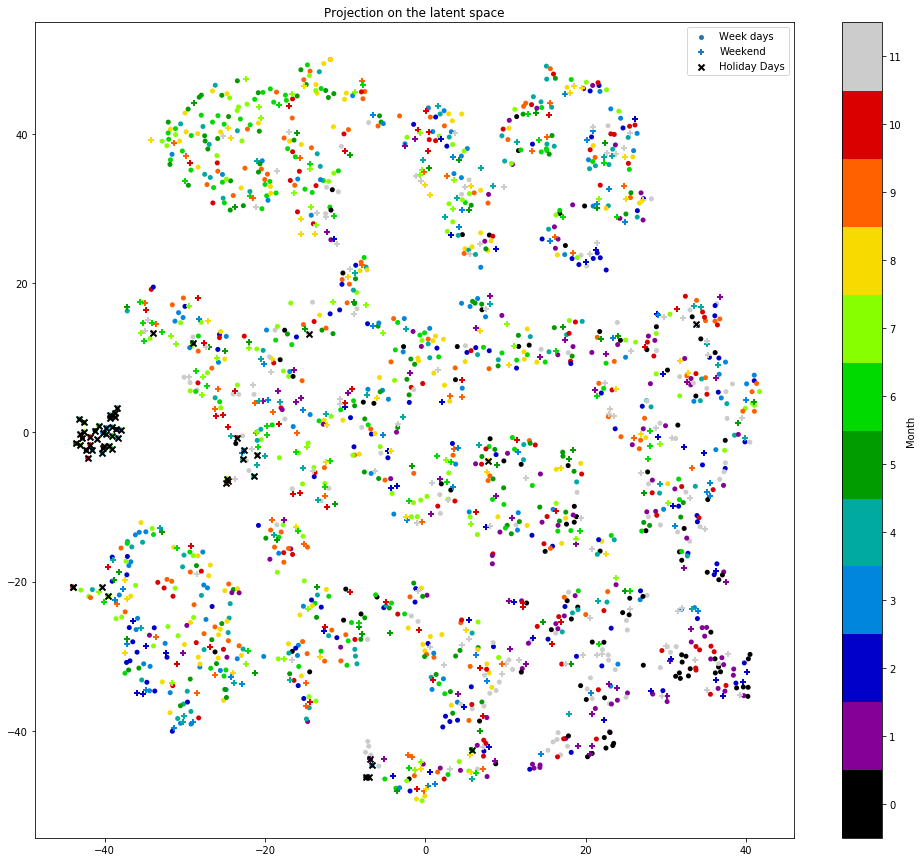

In [586]:
name_plot = 'z{}_n-{}_beta-{}_train-{}_set-{}_cond-{}{}'.format(str(z_dim),type_scaler,str(beta), name_train, name_set_plot,str(name_type_cond),version)
plot_latent_space_projection(x_proj=x_encoded, calendar_info=calendar_info,
                             path_folder_out=os.path.join(path_out,name_model,'results'), name=name_plot, 
                             pyplot=True, plotly = False)

In [587]:
temp = get_cond_autoencoder(dataset['train']['x'],dataset['train']['ds'], type_cond=['temp'], data_conso_df=data_conso_df)
temp = temp.flatten()

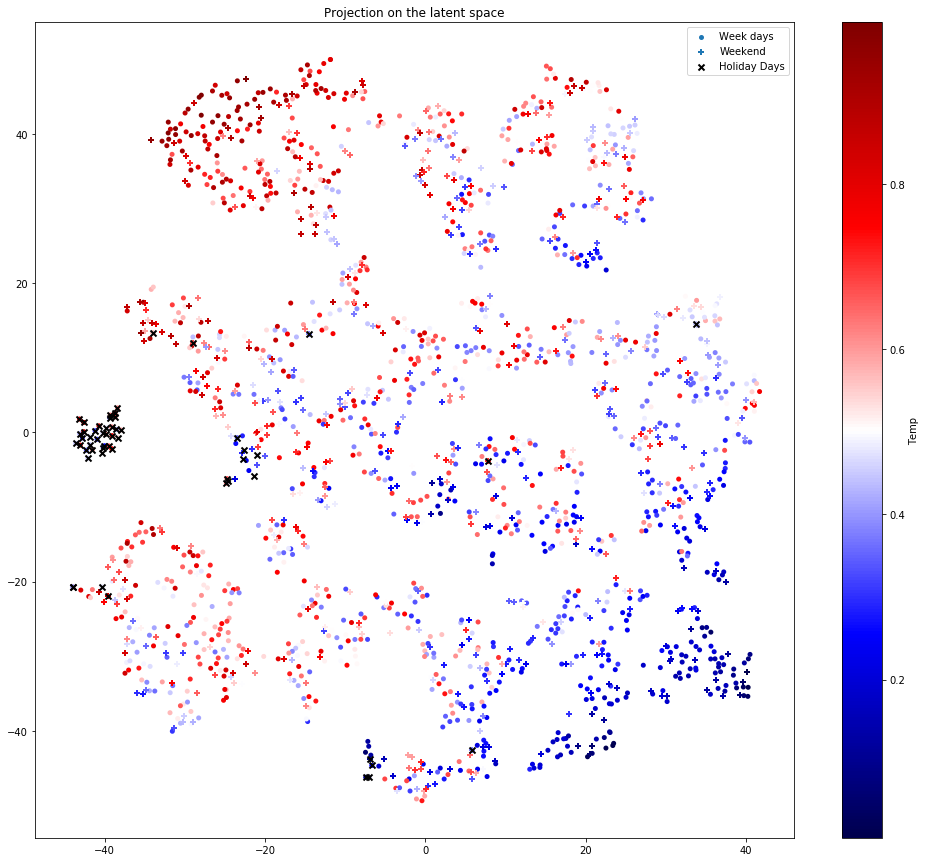

In [588]:
name_plot = 'temp_z{}_n-{}_beta-{}_train-{}_set-{}_cond-{}{}'.format(str(z_dim),type_scaler,str(beta), name_train, name_set_plot,str(name_type_cond),version)
pyplot_latent_space_projection_temp(x_encoded, calendar_info, temp,os.path.join(path_out,name_model,'results'), name_plot)

### Analyse of the reconstruction error

In [65]:
[x, cond] = dataset['train']['x']
x_hat = model.cvae.predict(x=[x, cond])

In [66]:
res_mat = (x - x_hat)
res = res_mat.mean(axis=1)

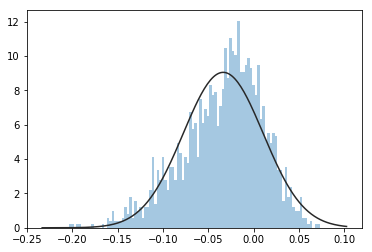

In [67]:
sn.distplot(res, kde=False, fit=stats.norm, bins=100)

In [69]:
res_conso_mat = res_mat[:,:48]
res_temp_mat = res_mat[:,48:]

In [70]:
res_conso = res_conso_mat.mean(axis=1)
res_temp = res_temp_mat.mean(axis=1)

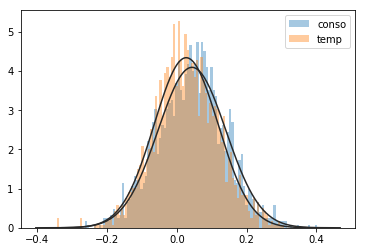

In [174]:
sn.distplot(res_conso, kde=False, fit=stats.norm, bins=100, label='conso')
sn.distplot(res_temp, kde=False, fit=stats.norm, bins=100, label='temp')
plt.legend()

In [536]:
results = dict()
results['me'] = {'all': res, 'temp': res_temp, 'conso': res_conso}

In [537]:
results['mae'] = {
    'all': np.apply_along_axis(lambda x: np.abs(x).mean(),1, res_mat),
    'conso': np.apply_along_axis(lambda x: np.abs(x).mean(),1, res_conso_mat),
    'temp': np.apply_along_axis(lambda x: np.abs(x).mean(),1, res_temp_mat)
}

In [538]:
results['z_score'] = {}
results['a_score'] = {}

for key, me in results['me'].items():
    z_score = stats.zscore(me)
    a_score = 1-2 * stats.norm.cdf(-np.abs(z_score))
    
    results['z_score'][key] = z_score
    results['a_score'][key] = a_score

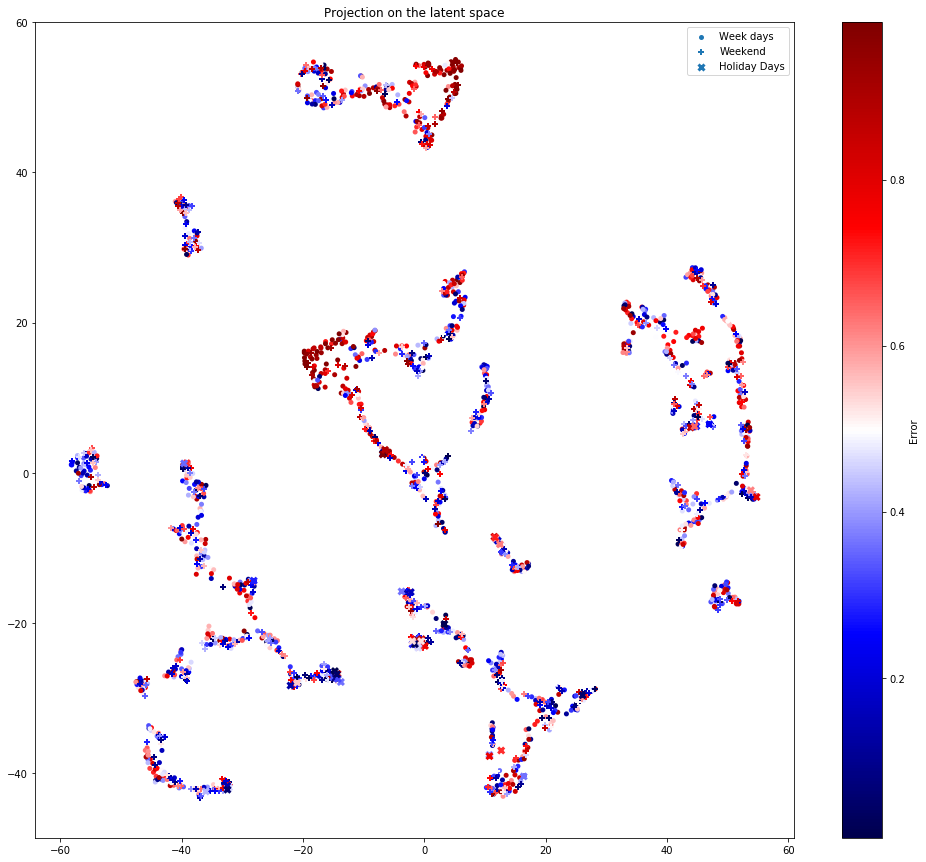

In [539]:
type_error = 'a_score'
type_data = 'all'

name_plot = '{}-{}_z{}_n-{}_beta-{}_train-{}_set-{}_cond-{}{}'.format(type_error, type_data,str(z_dim),type_scaler,str(beta), name_train, name_set_plot,str(name_type_cond),version)
path_plot = os.path.join(path_out,name_model,'results')

error = results[type_error][type_data]
pyplot_latent_space_projection_error(x_encoded, calendar_info, error, color='seismic', path_folder_out=path_plot, name=name_plot)

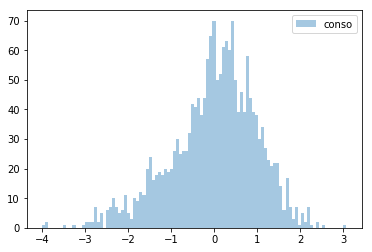

In [91]:
sn.distplot(results['z_score']['conso'], kde=False, bins=100, label='conso')
plt.legend()

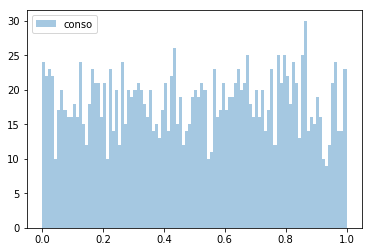

In [146]:
sn.distplot(results['a_score']['conso'], kde=False, bins=100, label='conso')
plt.legend()

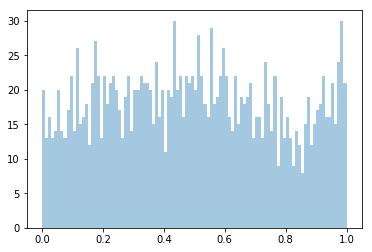

In [228]:
sn.distplot(stats.norm.cdf(results['z_score']['conso']), kde=False, bins=100, label='conso')

In [194]:
indice = 200

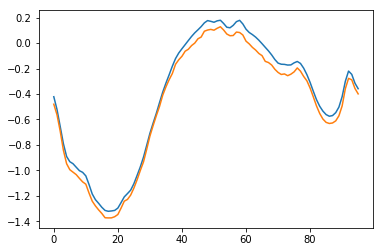

In [195]:
plt.plot(x[indice,])
plt.plot(x_hat[indice,])

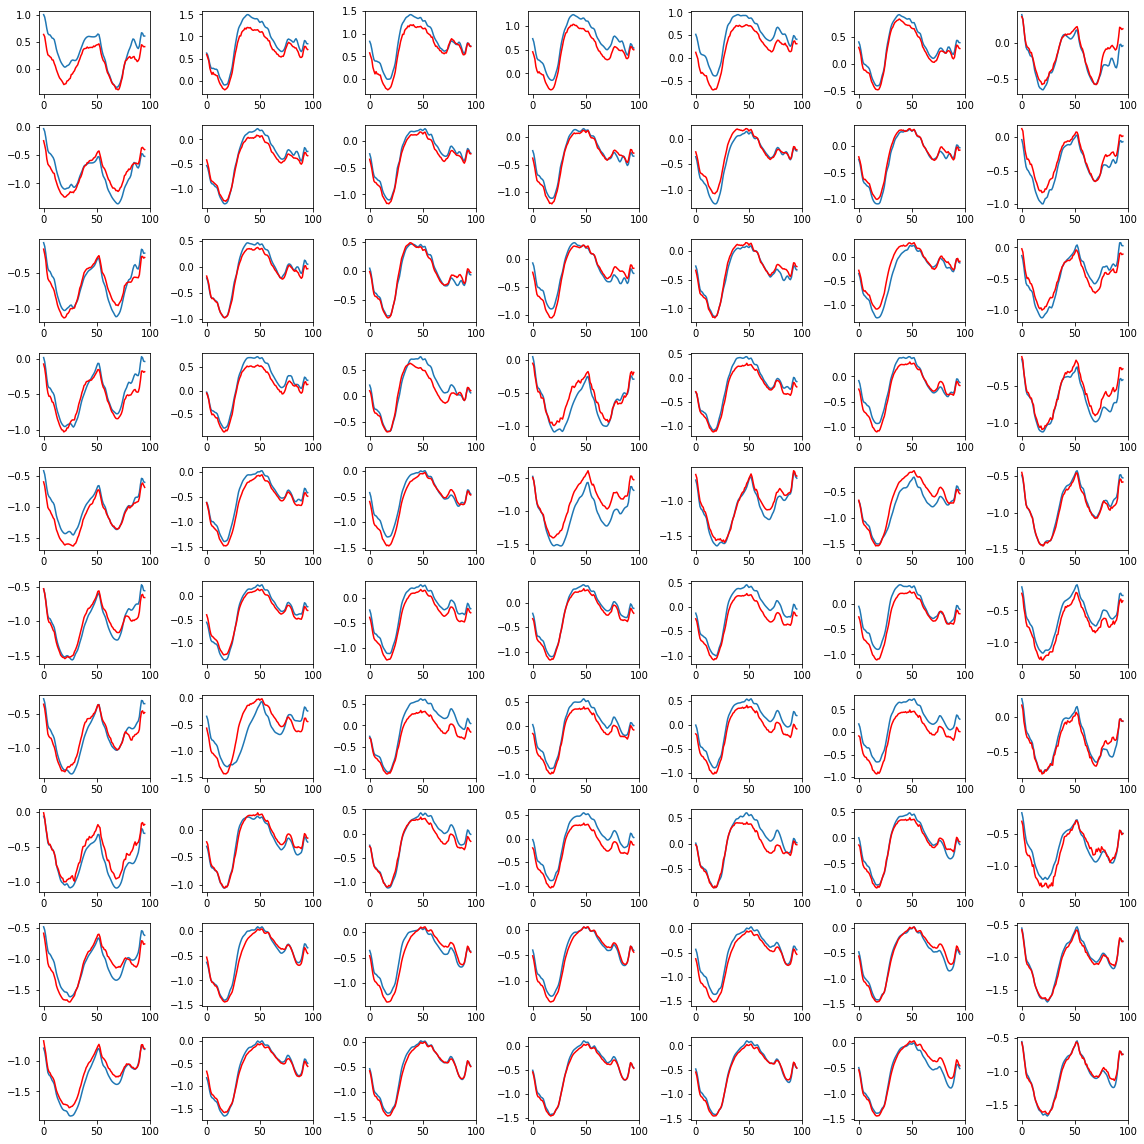

In [193]:
fig, axes = plt.subplots(10,7, figsize=(16,16))

ind = 100

for ax_row in axes:
    for ax in ax_row:
        # create a twin of the axis that shares the x-axis
        # plot some data on each axis.
        ax.plot(x[ind,:])
        ax.plot(x_hat[ind,:],'-r')
        
        ind+=1

plt.tight_layout()
plt.show()

In [228]:
model.history.keys()

dict_keys(['kl_loss', 'loss', 'recon_loss'])

In [229]:
el = model.history


In [231]:
el['kl_loss'][-1]

1.3353316627564977

In [85]:
path_out

'/home/antorosi/Documents/AutoEncoder/out'

In [606]:
l = [3,2,1]

In [608]:
l[:-1]

[3, 2]

In [609]:
l = [3]

In [610]:
l[:-1]

[]